# Описание проекта

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

#### Нам нужно:

* 1. Подготовить данные;
* 2. Провести исследовательский анализ данных;
* 3. Построить и обучить модель.

#### Предсказание коэффициента восстановления золота:
* Необходимо подготовить прототип модели машинного обучение для предсказания коэффициента восстановления золота из золотосодержащей руды.

#### Заказчик: 
* Компания, которая разрабатывает решения для эффективной работы промышленных предприятий. Прототип модели поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

#### Чтобы выполнить проект, обратимся к библиотекам *pandas*, *matplotlib* и *sklearn.* 

#### Проект состоит из 4-х частей



  - #### [1. Подготовка данных](#part1)
* 1.1. Описание данных
* 1.2. Импорт библиотек
* 1.3. Чтение файлов и изучение данных
* 1.3.1. Расчёт эффективности обогащения
* 1.3.2. Анализ признаков
* 1.4. Предобработка данных
  - #### [2. Анализ данных](#part2)
* 2.1. Анализ концентрации металлов на различных этапах очистки
* 2.2. Анализ размера гранул на обучающей и тестовой выборках
* 2.3. Анализ суммарной концентрации всех металлов на разных стадиях
  - #### [3. Модель](#part3)
* 3.1. Функция для расчета sMAPE
* 3.2. Обучение и сравнение моделей
* 3.3. Проверка модели на тестовой выборке
* 3.4. Проверка модели на адекватность
  - #### [4. Общий вывод](#part4)

## 1. Подготовка данных<a id='part1'></a>

* #### 1.1. Описание данных


#### Технологический процесс
#### Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

#### Параметры этапов

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

#### Наименование признаков

* Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра] 
* Пример: rougher.input.feed_ag

#### Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

#### Возможные значения для блока [тип_параметра]:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

* #### 1.2. Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML, Image
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', -1)

* #### 1.3. Чтение файлов и изучение данных

In [2]:
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')     # исходные данные
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')   # обучающая выборка
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')     # тестовая выборка

Объединим данные для удобства работы с ними

In [3]:
all_data = {'Исходные данные': full_data, 
            'Обучающая выборка': train_data, 
            'Тестовая выборка': test_data}

Выводим данные о всех таблицах на экран

In [4]:
for key, value in all_data.items():
    print(key)
    print(value.info())
    print()

Исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depress

Изучим первые и последние 5 строк полной таблицы с данными

In [5]:
display(full_data.head(5))
display(full_data.tail(5))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,7.962636,6.5,1.302419,6.612376,12.623947,7.542264,32.

Смотрим за какой период срез наших данных

In [6]:
print('Срез данных за период от', pd.to_datetime(full_data['date'].min()), 'до', pd.to_datetime(full_data['date'].max()))

Срез данных за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


Напишем функцию для вывода информации о пропусках по нашим данным, будем считать допустимым пропуски до 10% от всех данных

In [7]:
# функция для подсчета пропущенных значений в процентах
def missing_val(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['всего', 'процент пропусков'])
    missing_data['процент пропусков'] = missing_data['процент пропусков'].apply(lambda x: x * 100)
    display(missing_data.loc[missing_data['процент пропусков'] > 10][:10])
    

Выведем на экран количество признаков и процент пропущенных значений свыше 10%

In [8]:
for key, value in all_data.items():
    print(key + ':', value.shape)
    missing_val(value)
    print()
    

Исходные данные: (22716, 87)


,всего,процент пропусков
rougher.output.recovery,3119,13.730410
rougher.output.tail_ag,2737,12.048776
rougher.output.tail_sol,2736,12.044374
rougher.output.tail_au,2736,12.044374



Обучающая выборка: (16860, 87)


,всего,процент пропусков
rougher.output.recovery,2573,15.260973
rougher.output.tail_ag,2250,13.345196
rougher.output.tail_sol,2249,13.339265
rougher.output.tail_au,2249,13.339265
secondary_cleaner.output.tail_sol,1986,11.779359
rougher.input.floatbank11_xanthate,1904,11.293001



Тестовая выборка: (5856, 53)


,всего,процент пропусков


#### Вывод:

#### Исходные данные(full_data):

* таблица содержит 87 признака и 22716 объектов.
* содержит 1 категориальный признак (date) и 86 количественных признаков.
* тип данных для признака date - object необходимо преобразовать в datetime.
* обнаруженны пропуски:
* - rougher.output.recovery (13.7%),
* - rougher.output.tail_ag (12.0%),
* - rougher.output.tail_sol (12.0%),
* - rougher.output.tail_au (12.0%).

признаки относятся к параметрам продукта.

#### Обучающая выборка(train_data):

* таблица содержит 87 признака и 16860 объектов.
* содержит 1 категориальный признак (date) и 86 количественных признаков.
* обнаружены пропуски:
* - rougher.output.recovery (15.2%)
* - rougher.output.tail_ag (13.3%)
* - rougher.output.tail_sol (13.3%)
* - rougher.output.tail_au (13.3%)
* - secondary_cleaner.output.tail_sol (11.7%)
* - rougher.input.floatbank11_xanthate (11.3%)

признаки также относятся к параметрам продукта.


#### Тестовая выборка(test_data):

* таблица содержит 53 признака и 5856 объектов
* содержит 1 категориальный и 52 количественных признаков
* пропуски свыше 10% порога не обнаружены

#### 1.3.1. Расчёт эффективности обогащения:

Задача:

* Проверим, что эффективность обогащения рассчитана правильно. 
* Вычислим её на обучающей выборке для признака rougher.output.recovery.
* Найдем метрику MAE между нашими расчётами и значением признака.
* Напишем выводы.

Эффективность обогащения рассчитывается по формуле:

$$ Recovery = \frac{C × (F-T)}{F × (C-T)} × 100%$$
где:

* C — доля золота в концентрате после флотации/очистки
* F — доля золота в сырье/концентрате до флотации/очистки
* T — доля золота в отвальных хвостах после флотации/очистки.

Проверим, правильно ли она расчитана на примере признака rougher.output.recovery.

Выведем на экран все столбцы, названия которых содержит слово rougher(флотация):

создадим временную копию train_data для последующих манипуляций

In [9]:
train_data_temp = train_data.copy(deep=True) # создаем копию

In [10]:
display([col for col in train_data_temp.columns if 'rougher' in col])  # выводим на экран все столбцы с rougher

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

Используем следующие признаки для расчета Recovery:

* C — rougher.output.concentrate_au
* F — rougher.input.feed_au
* T — rougher.output.tail_au.

Результат расчета формулы сохраним в признаке rougher.output.recovery.

In [11]:
C = train_data_temp['rougher.output.concentrate_au']
F = train_data_temp['rougher.input.feed_au']
T = train_data_temp['rougher.output.tail_au']

train_data_temp['rougher.output.recovery.checked'] = (C * (F - T)) / (F * (C - T)) * 100 # вычисляем Recovery
display(train_data_temp['rougher.output.recovery.checked'].head(3)) # выведем первые три строки

0    87.107763
1    86.843261
2    86.842308
Name: rougher.output.recovery.checked, dtype: float64

Посчитаем метрику MAE между результатом проделанного расчета и значением признака rougher.output.recovery. Удалим пропуски из копии train_data.

In [12]:
train_data_temp.dropna(inplace=True) # удаляем пропуски
print('MAE:', 
      mean_absolute_error(train_data_temp['rougher.output.recovery'], 
                          train_data_temp['rougher.output.recovery.checked'])) # вычисление и вывод на экран метрики MAE

MAE: 9.555596961987514e-15


#### Вывод: 
* показатель метрики MAE весьма низок, эффективность обогащения рассчитана правильно

#### 1.3.2. Анализ признаков

Задача: 
* Проанализируем признаки, недоступные в тестовой выборке. 
* Что это за параметры?
* К какому типу относятся?

По предоставленным данным тестовая выборка содержит меньше признаков, нежели обучающая выборка.

При помощи функции set() создадим объекты множества и проверим, какие из признаков, которые доступны в обучающей выборке, недоступны в тестовой.

In [13]:
print('Разница в кол-ве признаков между обучающей и тестовой выборке:' , len(set(train_data) - set(test_data)))
display('Список признаков отсутсвующих в тестовой выборке:',set(train_data) - set(test_data))

Разница в кол-ве признаков между обучающей и тестовой выборке: 34


'Список признаков отсутсвующих в тестовой выборке:'

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Вывод:

В тестовой выборке недоступны признаки из блоков output (параметры продукта) и calculation (расчётные характеристики). Также в тестовой выборке отсутствуют целевые признаки:

* rougher.output.recovery — эффективность обогащения чернового концентрата

* final.output.recovery — эффективность обогащения финального концентрата

По вводным данным эти параметри в тестовой выборке недоступны, так как рассчитываются значительно позже.

Тип данных: float64

#### 1.4. Предобработка данных

* создадим копии датасетов.
* в копии каждой таблицы приведем признак date к типу данных datetime().
* обработаем пропуски.
* из копии обучающей выборки удалим те признаки, которые отсутсвуют в тестовой выборке.
* посмотрим на матрицу корреляций.


Создадим копии датасетов.

In [14]:
# создаем  копии
full_copy = full_data.copy(deep=True)
train_copy = train_data.copy(deep=True)
test_copy = test_data.copy(deep=True)
# объединяем в один датасет для удобства
datasets_copy = {'Исходные данные': full_copy, 
                 'Обучающая выборка': train_copy, 
                 'Тестовая выборка': test_copy}

In [15]:
# смотрим размеры таблиц
for key, value in datasets_copy.items():
    print(key + ':', value.shape)

Исходные данные: (22716, 87)
Обучающая выборка: (16860, 87)
Тестовая выборка: (5856, 53)


Приведем признак date к типу datetime()

In [16]:
for key, value in datasets_copy.items():
    value['date'] = pd.to_datetime(value['date'])
    print(value['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Обработаем пропуски:

добавим в тестовую выборку целевые признаки
из целевых признаков удалим строки с пропусками
для остальных признаков применим метод ffill и заполним пропуски с предыдущим значением строки, так как по вводным данным: данные индексируются датой и временем получения информации (признак date). **Соседние по времени параметры часто похожи.** 

In [17]:
test_copy = test_copy.merge(full_copy[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')
display(test_copy.shape)

(5856, 55)

Удалим строки с пропусками из целевых признаков.

In [18]:
cols = ['rougher.output.recovery', 'final.output.recovery']

full_copy.dropna(subset=cols, inplace=True)
train_copy.dropna(subset=cols, inplace=True)
test_copy.dropna(subset=cols, inplace=True)

Заполним пропуски в остальных признаках.

In [19]:
for key, value in datasets_copy.items():
    value.ffill(inplace=True)
    print(value.isnull().values.any())

False
False
False


Из копии обучающей выборки удалим те признаки, которых нету в тестовой. Таким образом в обучающей и в тестовой выборках останутся только те признаки, которые будем использовать при обучении модели.

In [20]:
useful_cols = list(test_copy.columns)
train_copy = train_copy[useful_cols]

Убедимся, что обучающая и тестовая выборки содержат одинаковое количество признаков.

In [21]:
print('Размер выборки train_copy:', train_copy.shape)
print('Размер выборки test_copy:', test_copy.shape)

Размер выборки train_copy: (14149, 55)
Размер выборки test_copy: (5290, 55)


Построим матрицу корреляции и проверим, есть ли признаки, которые сильно коррелируют с целевыми признаками. Зададим порог: уберем те признаки, где корреляция будет больше 0.5 и -0.5.

Для наглядности напишем функцию, для выделения строк, если корреляция между признаками будет выше 0.5 или ниже -0.5.

In [22]:

def highlight(val):
    color = 'red' if val < -0.5 else 'white'
    color = 'lightgreen' if val > 0.5 else 'white'
    return 'background-color: %s' % color

Построим матрицу корреляций.

In [23]:
correlation_map = train_copy.corr()
display(correlation_map[cols].style.applymap(highlight))

,rougher.output.recovery,final.output.recovery
primary_cleaner.input.sulfate,0.272823,0.384798
primary_cleaner.input.depressant,0.0413949,0.155639
primary_cleaner.input.feed_size,-0.0127951,0.0671566
primary_cleaner.input.xanthate,0.106701,0.214886
primary_cleaner.state.floatbank8_a_air,0.0871114,0.133526
primary_cleaner.state.floatbank8_a_level,0.0433767,0.0286312
primary_cleaner.state.floatbank8_b_air,0.100831,0.148987
primary_cleaner.state.floatbank8_b_level,0.0397768,0.0427555
primary_cleaner.state.floatbank8_c_air,0.114148,0.14367
primary_cleaner.state.floatbank8_c_level,0.0432485,0.0288939


Коррелирующих признаков по нашему условию нет, обучим модель на всех признаках датафрейма train_copy.



#### Вывод: 

* загрузили и изучили данные для каждой таблицы
* проверили, что эффективность обогащения рассчитана правильно
* проанализировали признаки, недоступные в тестовой выборке
* провели предобработку данных:
* обработали пропуски
* признак date привели к типу datatime()
* подготовили обучающую и тестовую выборки для дальнейшей работы: оставили в обоих выборках одинаковое к-во признаков(удалили из обучающей те признаки которые отсутствуют в тестовой).


# 2. Анализ данных<a id='part2'></a>

#### 2.1. Анализ концентрации металлов на различных этапах очистки
Задача:
* посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 
* опишем выводы.
* из копии датасета с исходными данными отберем признаки, которые характеризуют концентрацию металлов (Au, Ag, Pb) на различных этапах очистки.

Напишем функцию для визуализации концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

In [24]:
# создаем словарь с названиями элементов 
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

# 'x' как аргумент функции, принимает название металла 
# возвращает информацию о распределении концентрации металла на различных этапах очистки
    
def plot_concentrate(x):
    
    cols = ['rougher.input.feed_'+x, 'rougher.output.concentrate_'+x, 
            'primary_cleaner.output.concentrate_'+x, 'final.output.concentrate_'+x]
    
    concentrate = full_copy[cols]    
    
    full_copy[cols].plot(kind='kde', figsize=(12,8) )
    
    plt.title('Концентрация  ' + str(x).title() + ' на этапах очистки', fontsize=16)
    
    plt.figure(figsize=(12.8,8))
    plt.xticks(rotation=0)
    sns.boxplot(data=full_copy[cols])

Вызываем функцию и смотрим на графики

Смотрим на графики золота

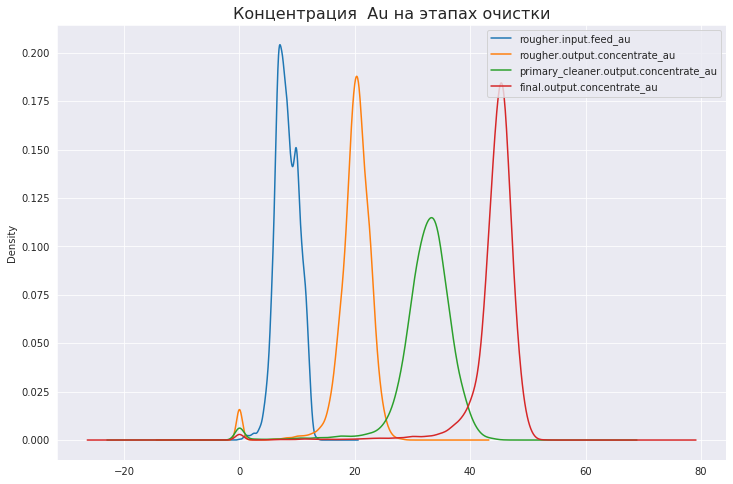

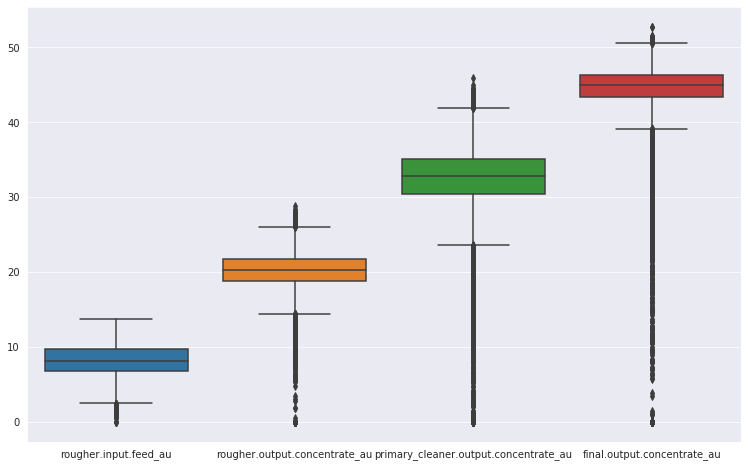

In [25]:
plot_concentrate(elements['золото'])

Судя по графикам, концентрация золота с каждым этапом очистки увеличивается, что в принципе логично. Наименьшая концентрация золота на этапе сырья(rougher.input.feed_au), а самый высокий показатель на финальном этапе (final.output.concentrate_au).
Также виден всплеск на нулевых значениях.

"Ящики с усами" показывают что в данных присутствуют выбросы (на всех этапах очистки).



Посмотрим на концентрацию серебра

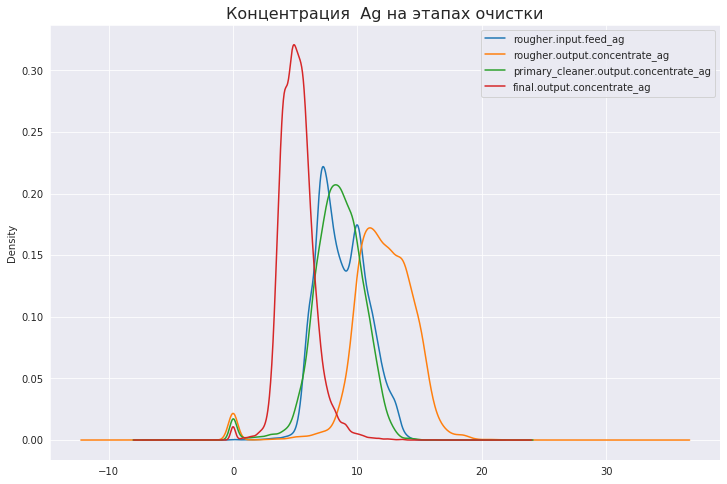

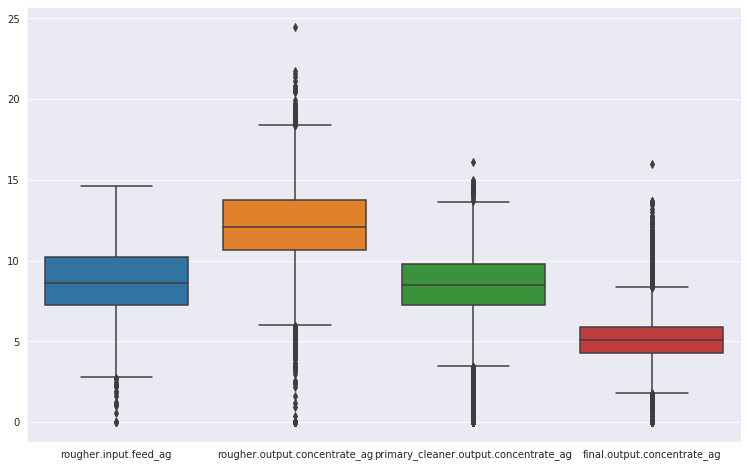

In [26]:
plot_concentrate(elements['серебро'])

Концентрация серебра с каждым этапом очистки уменьшается, максимальную концентрацию серебра мы видим после второго этапа очистки. Так же присутсвуют всплески нулевых значений и выбросы.

Смотрим на концентрацию свинка на этапах очистки

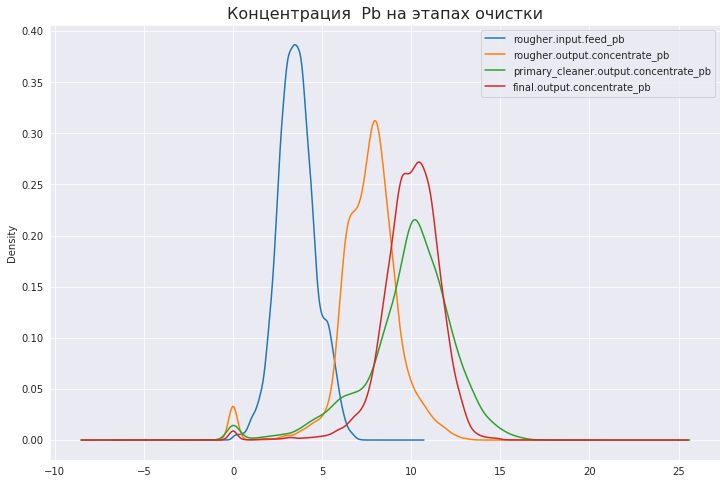

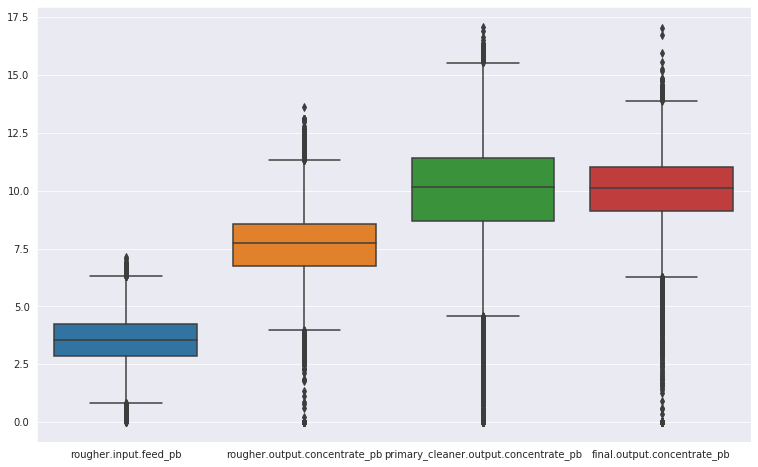

In [27]:
plot_concentrate(elements['свинец'])

Графики показывают, что концентрация свинца увеличивается на первых 3-х этапах очистки. Видимо концентрация растет наряду с концентрацией золота, возможно что стадии очистки не так эффективны по отношению к свинцу.

В данных есть выбросы и всплески нулевых значений.

#### Вывод: 

* Судя по графикам, концентрация золота с каждым этапом очистки увеличивается, что в принципе логично. Наименьшая концентрация золота на этапе сырья(rougher.input.feed_au), а самый высокий показатель на финальном этапе (final.output.concentrate_au). Также виден всплеск на нулевых значениях."Ящики с усами" показывают что в данных присутствуют выбросы (на всех этапах очистки).
* Концентрация серебра с каждым этапом очистки уменьшается, максимальную концентрацию серебра мы видим после второго этапа очистки. Так же присутсвуют всплески нулевых значений и выбросы.
* Графики показывают, что концентрация свинца увеличивается на первых 3-х этапах очистки. Видимо концентрация растет наряду с концентрацией золота, возможно что стадии очистки не так эффективны по отношению к свинцу.

#### 2.2. Анализ размера гранул на обучающей и тестовой выборках

Задача: 
* сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 
* если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Чтобы сравнить распределения размеров гранул сырья на обучающей и тестовой выборках:
* методом describe() посмотрим на статистические данные признаков primary_cleaner.input.feed_size и rougher.input.feed_size на обучающей и тестовой выборках
* построим график распределение размеров гранул сырья на обучающей и тестовой выборках.

Посмотрим на график и различия распределения гранул на сырье

In [28]:
# объединим выборки для удобства отображения и сравнения
rougher_input_feed_size = pd.concat([train_copy['rougher.input.feed_size'], 
                                     test_copy['rougher.input.feed_size']], axis=1) 
# выделим два нужных нам столбца для вызова метода describe()
rougher_input_feed_size.columns = ['train', 'test']
display(rougher_input_feed_size.describe())

,train,test
count,14149.000000,5289.000000
mean,60.239856,55.951097
std,23.005310,19.081758
min,9.659576,0.046369
25%,48.966751,43.906347
50%,55.269784,50.841029
75%,66.007526,62.431047
max,484.967466,392.494040


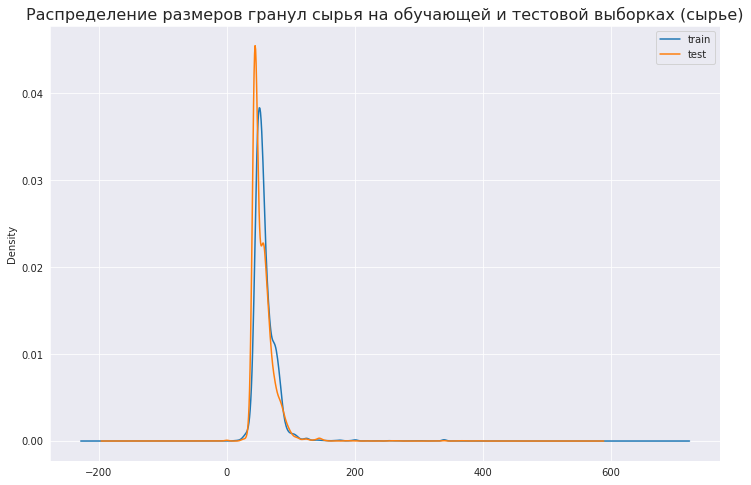

In [29]:
rougher_input_feed_size.plot(kind='kde', figsize=(12,8))
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках (сырье)', fontsize=16)
plt.show()

Посмотрим на график и различия распределения гранул на первичной очистке

In [30]:
# объединим выборки для удобства отображения и сравнения
primary_cleaner_input_feed_size = pd.concat([train_copy['primary_cleaner.input.feed_size'], 
                                     test_copy['primary_cleaner.input.feed_size']], axis=1) 
# выделим два нужных нам столбца для вызова метода describe()
primary_cleaner_input_feed_size.columns = ['train', 'test']
display(primary_cleaner_input_feed_size.describe())

,train,test
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


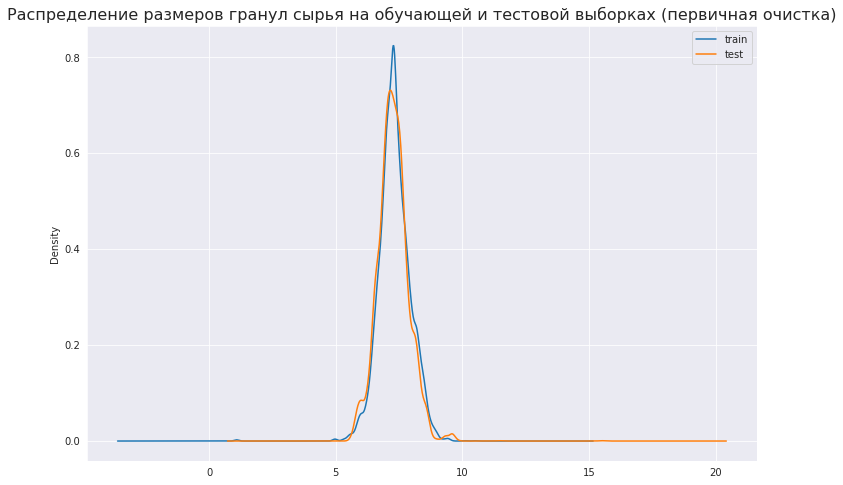

In [31]:
primary_cleaner_input_feed_size.plot(kind='kde', figsize=(12,8))
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках (первичная очистка)', fontsize=16)
plt.show()

#### Вывод:
* В обоих случаях различия в размерах гранул незначительны на обучающей и тестовой выборках. Предположим что это не повлияет отрицательно на обучение модели.

#### 2.3. Анализ суммарной концентрации всех металлов на разных стадиях
Задача: 
* исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
* найдем аномальные значения в суммарном распределении если они есть.
* если они есть, подумаем стоит ли их удалять из обеих выборок.
* опишем выводы и удалим аномалии(при наличии).

Из датафрейма full_copy отберем те признаки, которые характеризуют концентрацию веществ (Au, Ag, Pb) на разных стадиях. Для каждой стадии посчитаем общую концентрацию всех металлов.

In [32]:
# присвоим переменным нужные значения
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'
# суммируем данные и добавим в таблицу с названиями столбцов
full_copy['сырье'] = full_copy[[first+'au', first+'ag', first+'pb']].sum(axis=1)
full_copy['черновой концентрат'] = full_copy[[second+'au', second+'ag', second+'pb']].sum(axis=1)
full_copy['концентрат после очистки'] = full_copy[[third+'au', third+'ag', third+'pb']].sum(axis=1)
full_copy['финальный концентрат'] = full_copy[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

Методом describe() посмотрим общие характеристики полученных столбцов.

In [33]:
display(full_copy[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe())

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,20.646120,39.373032,50.372125,59.223721
std,4.480027,6.863389,7.628095,6.095138
min,0.030000,0.000000,0.000000,0.000000
25%,17.252879,38.394639,50.053899,59.298323
50%,20.141216,40.312648,51.909156,60.306921
75%,23.797381,42.365102,53.386898,61.096667
max,33.498784,55.568687,60.269003,64.968881


Построим графики распределения.

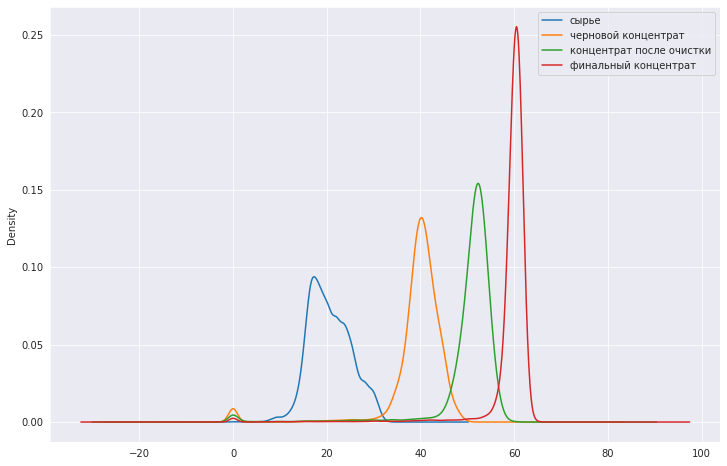

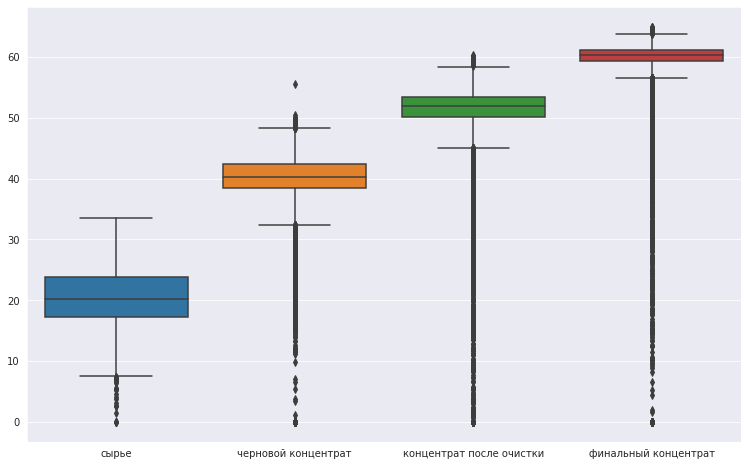

In [34]:
cols_all = ['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']
    
concentrate = full_copy[cols_all]    
    
full_copy[cols_all].plot(kind='kde', figsize=(12,8))

plt.figure(figsize=(12.8,8))
plt.xticks(rotation=0)
sns.boxplot(data=full_copy[cols_all])
plt.show()

В наших данных присутствуют выбросы (на всех стадиях очистки). Избавимся от них чтобы правильно обучить нашу модель.
Присутсвуют нулевые значения в суммарных концентрациях во всех металлах на этапах: черновой концентрат, концентрат после очистки и финальный концентрат. Удалим нулевые элементы, которые могут негативно повлиять на работу модели.

Проверим, сколько объектов, где суммарная концентрация металлом равна 0 и сколько таких, где меньше 1.

In [35]:
for col in cols_all:
    print(col, ', нулевые значения:', len(full_copy[full_copy[col] == 0]))
    print(col, ', значения меньше одного:', len(full_copy[full_copy[col] < 1]))
    print('\n')

сырье , нулевые значения: 0
сырье , значения меньше одного: 5


черновой концентрат , нулевые значения: 394
черновой концентрат , значения меньше одного: 399


концентрат после очистки , нулевые значения: 108
концентрат после очистки , значения меньше одного: 229


финальный концентрат , нулевые значения: 98
финальный концентрат , значения меньше одного: 99




Сделаем срез данных из full_copy, оставим объекты где суммарная концентрация металла больше 1.

In [36]:
full_clean = full_copy[
    (full_copy['сырье'] >  1) & 
    (full_copy['черновой концентрат'] > 1) & 
    (full_copy['концентрат после очистки'] > 1) & 
    (full_copy['финальный концентрат'] > 1)
]

display(full_clean.shape)

(18721, 91)

Проверим результат

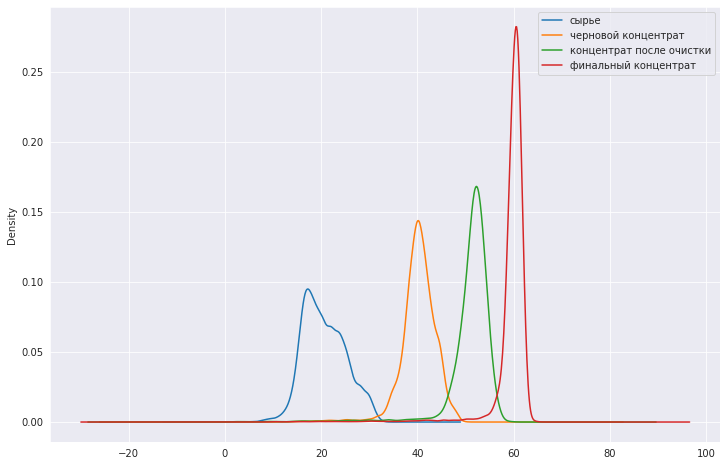

In [37]:
full_clean[['сырье', 'черновой концентрат',
            'концентрат после очистки', 'финальный концентрат']].plot(kind='kde', figsize=(12,8))
plt.show()

In [38]:
display(full_clean[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe())

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
count,18721.000000,18721.000000,18721.000000,18721.000000
mean,20.650243,40.212048,50.964122,59.537313
std,4.431189,3.823193,5.209286,4.263810
min,2.560855,1.137053,1.037408,1.685441
25%,17.238008,38.537325,50.123640,59.307366
50%,20.136186,40.381394,51.916945,60.303141
75%,23.787611,42.411418,53.362292,61.086650
max,33.498784,55.568687,60.106566,64.968881


Избавились от аномалий, и на всех стадиях минимальный показатель суммарной концентрации металлов выше 1.
Таким образом мы уменьшили разброс данных, о чем свидетельствует низкие показатели стандартного отклонения (std).

Удалим из обучающего и тестового датасета объекты, которые мы удалили из датасета full_clean. Для корректного обучения модели. Для этого создадим выборки по признаку date

In [39]:
# создаем выборки
train_clean = train_copy[train_copy['date'].isin(full_clean['date'])]
test_clean = test_copy[test_copy['date'].isin(full_clean['date'])]

train_clean.dropna(inplace=True) # удаляем пропуски
test_clean.dropna(inplace=True)  # удаляем пропуски
# смотрим на размер выборок
print('Обучающая выборка', train_clean.shape)
print('Тестовая выборка', test_clean.shape)

Обучающая выборка (13598, 55)
Тестовая выборка (5074, 55)


#### Вывод:
* увидели как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
* концентрация каждого из металлов меняется в зависимости от этапа очистки. Так, например, концентрация золота и свинца постепенно увеличивается с каждым этапом, а серебра — падает.
* на всех этапах очистки в данных присутствуют выбросы и всплески нулевых значений.
* анализ размера гранул на обучающей и тестовой выборках показал, что размеры гранул примерно одинаково распределены в обоих выборках.
* суммарная концентрации всех металлов на разных стадиях показала наличие аномалий (нулевые значения концентрации) удалили их.

# 3. Модель<a id='part3'></a>

#### 3.1. Функция для расчета sMAPE
#### (метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Задача: 
* Напишем функцию для вычисления итоговой sMAPE.
* Напишем функцию для расчета метрики sMAPE, которая вычисляется по следующей формуле:

$$ sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} × 100% $$
где:

* $y_i$ — значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
* $\hat{y_i}$ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
* N — количество объектов в выборке
* $\sum_{i=1}^{N}$ — суммирование по всем объектам выборки (i меняется от 1 до N).

In [40]:
# функция для вычисления метрики smape
def smape(target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    summa = (numerator / denominator).sum()

    smape = 1 / len(target) * summa * 100
    return smape

Итоговая метрика качества sMAPE final складывается из двух величин:

$$ sMAPE final = 0.25 × sMAPE(rougher) + 0.75 × sMAPE(final)$$

Напишем функцию для расчета sMAPE final.

In [41]:
# функция для вычисления финальной метрики smape
def smape_final(smape_rougher, smape_final):
    smape_final = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_final

#### 3.2. Обучение и сравнение моделей
Задача: 
* обучим разные модели и оценим их качество кросс-валидацией.
* выберем лучшую модель и проверим её на тестовой выборке. 
* опишем выводы.

Сохраним признаки и целевые признаки в отдельные переменные.

In [42]:
target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

# test выборка
target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [43]:
print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (13598, 52)
features_test (5074, 52)


Масштабируем признаки для корректного обучения модели. Используем структуру для стандартизации данных из библиотеки sklearn — StandardScaler.

In [44]:
# масштабируем признаки
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [45]:
# выведем результат стандартизации на экран
display(features_train.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.177039,0.374634,-0.128322,0.283117,-0.446599,-0.299217,-0.428651,-0.810462,-0.433391,-0.276266,0.054272,-0.218111,-1.317175,-1.124608,0.474291,-0.204538,0.103504,-0.734998,0.080414,0.119141,0.129165,0.144100,-0.732432,-0.348957,1.534163,0.506719,1.410552,0.401452,1.839913,0.247049,1.697976,0.158910,2.155394,0.217686,-0.665181,0.054688,-0.171481,0.029153,-0.937518,-0.318633,-0.146099,-0.257408,-1.050803,-0.476117,-0.642255,-0.759903,-1.178724,-0.384014,-0.864161,-0.430466,-0.960817,-2.679757
1,-0.214782,0.424724,-0.128322,0.320132,-0.241337,-0.355833,-0.241880,-0.321604,-0.238985,-0.295026,0.125861,-0.337348,-1.284866,-1.142032,0.491348,-0.127228,-0.111049,-0.739010,0.075603,0.117095,0.172385,0.149638,-0.728987,-0.306576,1.521753,0.241252,1.401607,0.264947,1.847526,0.271111,1.669885,0.240183,2.060624,0.249883,-0.660439,0.030300,-0.172171,0.045658,-0.935964,-0.406801,-0.117086,-0.259918,-1.055140,-0.535469,-0.670620,-0.702030,-1.159205,-0.432692,-0.880625,-0.433308,-0.987551,-2.516067
2,-0.261469,0.728935,-0.128322,0.289790,-0.043863,-0.330060,-0.055721,-0.343534,-0.045404,-0.340007,0.215070,-0.356756,-1.308623,-1.240242,0.537662,-0.117220,-0.066674,-0.800714,0.059824,0.293380,0.151819,0.306597,-0.732357,-0.306670,1.513960,0.240292,1.397800,0.262731,1.844279,0.271101,1.669638,0.256679,2.064026,0.242665,-0.638882,0.031300,-0.172651,0.052371,-0.946087,-0.395043,0.256693,-0.270701,-1.051125,-0.476765,-0.677787,-0.698642,-1.153765,-0.431623,-0.875573,-0.431657,-0.982254,-2.560408
3,-0.301453,0.730682,-0.128322,0.304361,-0.056210,-0.357163,-0.053644,-0.316023,-0.058052,-0.335898,0.218302,-0.361633,-1.347534,-1.352667,0.660523,-0.105051,0.114412,-0.930119,-0.030787,0.298716,0.090046,0.300013,-0.731791,-0.308006,1.517930,0.229641,1.399405,0.263518,1.834111,0.267943,1.679076,0.255042,2.063559,0.255686,-0.649727,0.043849,-0.161146,0.054017,-0.936624,-0.405399,0.256039,-0.271713,-1.047328,-0.444019,-0.661313,-0.699673,-1.171039,-0.407346,-0.881914,-0.424969,-0.986293,-2.521715
4,-0.411939,0.907081,-0.128322,0.339316,-0.045547,-0.301016,-0.047713,-0.335124,-0.063427,-0.340530,0.226133,-0.373342,-1

Признаки масштабированны

Оценим качество разных моделей при помощи кросс-валидации.

In [46]:
random_state = 123 # зададим рандомное число
cv = 5 # кросс валидация для 5-ти выборок

In [47]:
# объявим модели для кроссвалидации
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

In [48]:
# переменная для данных по моделям и метрикам
results_cross_val = []
for model in models: 
    
    scorer = make_scorer(smape, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_rougher_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_final_train, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
display(pd.DataFrame(results_cross_val).style.highlight_max(color = 'lightgreen', axis = 0))

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-9.5698,-15.8983
1,RandomForestRegressor,-6.75133,-10.4629
2,LinearRegression,-7.28162,-11.026


Лучший результат показала модель RandomForestRegressor. Подбором гиперпараметров попробуем улучшить работу модели. Все полученные данные соберем в таблицу и выведем на экран.

In [49]:
%%time 
results = []

for depth in range(1,5):
    
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(smape, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = smape_final(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'smape_final_result': smape_final_result})

display(pd.DataFrame(results).style.highlight_max(color = 'lightgreen', axis = 0))

,model name,Hyperparameters,smape_final_result
0,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 1}",-9.05051
1,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 1}",-9.05429
2,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 1}",-9.00978
3,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 2}",-8.56631
4,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 2}",-8.54308
5,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 2}",-8.52996
6,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 3}",-8.35943
7,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 3}",-8.36779
8,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 3}",-8.34491
9,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 4}",-8.41238


CPU times: user 3min 36s, sys: 192 ms, total: 3min 36s
Wall time: 3min 41s


Лучший результат модель показала с гиперпараметрами n_estimators = 20 и max_depth = 3. Проверим работу модели с подобранными гиперпараметрами на тестовой выборке.

#### 3.3. Проверка модели на тестовой выборке
Обучим модель случайного леса с гиперпараметрами n_estimators = 20 и max_depth = 3 на тестовой выборке.

In [50]:
model_final = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=20, 
                                       max_depth=3)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)

Вычисляем метрики smape и smape final

In [51]:
smape_r = smape(target_rougher_test, predictions_r)
smape_f = smape(target_final_test, predictions_f)

print('Итоговое sMAPE:', smape_final(smape_r, smape_f))

Итоговое sMAPE: 7.04350757964738


#### 3.4. Проверка модели на адекватность
Для проверки модели на адекватность используем DummyRegressor из библиотеки Skelarn.

Создадим простейшую baseline модель для проверки на адекватность нашей модели, она представляет собой простейшую (dummy) модель, которая всегда предсказывает среднее значение класса.

In [52]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy.predict(features_test)

dummy.fit(features_train, target_final_train)
predictions_f_dummy = dummy.predict(features_test)

Вычислим значения метрик smape на DummyRegressor

In [53]:
smape_r_dummy = smape(target_rougher_test, predictions_r_dummy)
smape_f_dummy = smape(target_final_test, predictions_f_dummy)

print('Итоговое sMAPE', smape_final(smape_r_dummy, smape_f_dummy))

Итоговое sMAPE 7.684349886589512


Ошибка обученной модели составляет 7.04%, baseline модели - 7.68%. Прототип нашей модели показывает полную адекватность. Модель готова.

#### Вывод:
* создали функции для расчёта sMAPE и итоговой sMAPE
* сравнили несколько моделей (DecisionTreeRegressor (), RandomForestRegressor, LinearRegression)
* подобрали гиперпараметры для лучшей модели RandomForestRegressor
* протестировали  модель RandomForestRegressor с гиперпараметрами n_estimators = 20 и max_depth = 3 на тестовой выборке и проверили модель на адекватность.
* ошибка обученной модели составляет 7.04%, baseline модели - 7.68%. Прототип нашей модели показывает адекватность. Модель готова




# 4. Общий вывод<a id='part4'></a>

* изучены данные 
* проведена предобработка данных (обработка пропусков, замена типа данных)
* проведен анализ признаков и подготовка выборки для дальнейшей работы (оставили в обучающей и тестовой выборках одинаковое к-во признаков)
* проверили, что эффективность обогащения рассчитана правильно.
* изучили, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.
* концентрация каждого из металлов меняется в зависимости от этапа очистки: концентрация золота постепенно увеличивается с каждым этапом, серебра — падает, а свинца растёт на первых 3-х этапах.
* проведен анализ размера гранул на обучающей и тестовой выборках и убедились, что размеры гранул примерно одинаково распределены в обучающей и тестовой выборках.
* проведен анализ суммарной концентрации всех металлов на разных стадиях, обнаружены и удалены аномалии (нулевые всплески) из всех таблиц данных.
* создали функции для расчёта sMAPE и итоговой sMAPE
* сравнили несколько моделей  (DecisionTreeRegressor , RandomForestRegressor, LinearRegression) выбрали лучшую модель RandomForestRegressor
* подобрали гиперпараметры для лучшей модели RandomForestRegressor (гиперпараметры n_estimators = 20 и max_depth = 3)
* обученную модель RandomForestRegressor протестировали на тестовой выборке, где она показала хороший результат: ошибка обученной модели составляет 7.04%, baseline модели - 7.68%. Модель адекватна, и готова к дальнейшему использованию.





